In [1]:
import sys
sys.path.append("repo/src")

import torch
import torch.nn as nn
import numpy as np

from VPINN import *
import torch_derivatives as td
import quadrature_rules as qr
from utils import *
from train import train

from tqdm import tqdm

import matplotlib.pyplot as plt

# MLP where we can define the initialization

In [2]:
# The module will compute sin(w*x)
class MLP(nn.Module):
    
    def __init__(self, w):
        
        super().__init__()
        
        self.lin1 = nn.Linear(1, 1, bias = False)
        self.lin1.weight.data = torch.tensor([w], dtype = torch.double)
        
    def forward(self, x):
        x = x.view(-1,1)
        return torch.sin(self.lin1(x))

# Computation of analytical losses and gradients

In [3]:
def computeLossInterior1(vpinn, w):

    x = vpinn.x.view(-1)

    return (torch.sum(vpinn.weights * (vpinn.source - w**2 * torch.sin(w*x)) * vpinn.test_functions, dim = 1)**2).mean()

def computeLossInterior2(vpinn, w):

    x = vpinn.x.view(-1)

    return (torch.sum(vpinn.weights * (w* torch.cos(w*x) - vpinn.source) * vpinn.test_functions, dim = 1)**2).mean()

def computeLossInterior2(vpinn, w):

    x = vpinn.x.view(-1)

    loss = torch.sum(vpinn.weights * w * torch.cos(w*x) * vpinn.dtest_functions, dim = 1)
    loss = loss - torch.sum(vpinn.weights * vpinn.source * vpinn.test_functions, dim = 1)

    return torch.mean(loss**2)

def computeLossInterior3(vpinn, w):

    x = vpinn.x.view(-1)
    w = torch.tensor([w], dtype = torch.double)

    loss = - torch.sum(vpinn.weights * torch.sin(w*x) * vpinn.d2test_functions, dim = 1)
    loss = loss + vpinn.u_right  * vpinn.dtest_functions[:,-1] - vpinn.u_left * vpinn.dtest_functions[:,0]
    loss = loss - torch.sum(vpinn.weights * vpinn.source * vpinn.test_functions, dim = 1)
    
    return torch.mean(loss**2)

def computeLossBoundary(vpinn, w):
    w = torch.tensor([w], dtype = torch.double)

    loss = (torch.sin(w) + vpinn.u_left)**2 + (torch.sin(w) - vpinn.u_right)**2
    return 0.5*vpinn.boundary_penalty*loss

def computeLoss(vpinn, w, method):
    if method == 1: loss_interior = computeLossInterior1(vpinn, w)
    elif method == 2: loss_interior = computeLossInterior2(vpinn, w)
    elif method == 3: loss_interior = computeLossInterior3(vpinn, w)
    
    loss_boundary = computeLossBoundary(vpinn, w)
    return loss_interior + loss_boundary

def computeInteriorGrad1(vpinn, w):

    x = vpinn.x.view(-1)

    tmp = torch.sum(vpinn.weights * (vpinn.source - w**2 * torch.sin(w*x)) * vpinn.test_functions, dim = 1)
    grad = -torch.sum(vpinn.weights * w *(2*torch.sin(w*x) + w*x*torch.cos(w*x)) * vpinn.test_functions, dim = 1)
    grad = 2 * (grad * tmp).mean()

    return grad

def computeInteriorGrad2(vpinn, w):

    x = vpinn.x.view(-1)

    tmp = torch.sum(vpinn.weights * w * torch.cos(w*x) * vpinn.dtest_functions, dim = 1)
    tmp = tmp - torch.sum(vpinn.weights * vpinn.source * vpinn.test_functions, dim = 1)

    grad = torch.sum(vpinn.weights * (torch.cos(w*x) - w*x*torch.sin(w*x)) * vpinn.dtest_functions, dim = 1)
    grad = grad * tmp

    return 2*grad.mean()

def computeInteriorGrad3(vpinn, w):

    x = vpinn.x.view(-1)
    w = torch.tensor([w], dtype = torch.double)

    tmp = - torch.sum(vpinn.weights * torch.sin(w*x) * vpinn.d2test_functions, dim = 1)
    tmp = tmp + vpinn.u_right  * vpinn.dtest_functions[:,-1] - vpinn.u_left * vpinn.dtest_functions[:,0]
    tmp = tmp - torch.sum(vpinn.weights * vpinn.source * vpinn.test_functions, dim = 1)

    grad = -torch.sum(vpinn.weights * x * torch.cos(w*x) * vpinn.d2test_functions, dim = 1)
    grad = grad * tmp

    return 2*grad.mean()

def computeBoundaryGrad(vpinn, w):
    w = torch.tensor([w], dtype = torch.double)

    grad = 2*torch.sin(w) + vpinn.u_left - vpinn.u_right
    grad = vpinn.boundary_penalty * torch.cos(w) * grad

    return grad

def computeGrad(vpinn, w, method):

    if method == 1: grad_interior = computeInteriorGrad1(vpinn, w)
    elif method == 2: grad_interior = computeInteriorGrad2(vpinn, w)
    elif method == 3: grad_interior = computeInteriorGrad3(vpinn, w)
    grad_boundary = computeBoundaryGrad(vpinn, w)

    return grad_interior + grad_boundary

# VPINN

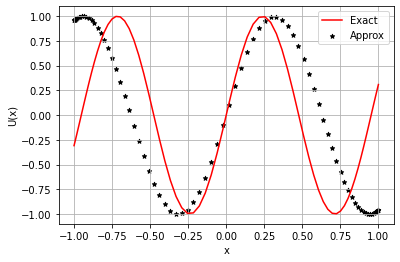

In [4]:
# Problem Parameters

a, b = -1, 1
A, w = 1., 2.1*np.pi
u_ex = lambda x: A*torch.sin(w*x)
u_left = A*torch.sin(torch.tensor([a*w], dtype = torch.double))
u_right = A*torch.sin(torch.tensor([b*w], dtype = torch.double))
source = lambda x: A * w**2 * torch.sin(w*x)


# Model Parameters
method = 1
num_points = 80
num_sine_test_functions = 5
num_poly_test_functions = 5
boundary_penalty = 5

# Optimization Parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_iter = 1000
lr = 1

u_approx = MLP(5)
vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                    num_points, num_sine_test_functions, num_poly_test_functions, 
                                    boundary_penalty, u_approx, u_ex, device =  device)
optimizer = torch.optim.Adam(vpinn.parameters(), lr = lr)
vpinn.plot()

# Verifiy the gradients are well computed after 1 iteration

#### Method 1

In [5]:
diffs1 = []

for w_param in np.logspace(-10, 1, 10):

    u_approx = MLP(w_param)
    vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)
    analyticGrad = computeGrad(vpinn, w_param, 1)

    loss_interior, loss_boundary = vpinn.compute_loss(1)
    vpinnLoss = loss_interior + loss_boundary
    vpinnLoss.backward()

    for p in vpinn.model.parameters():
        vpinnGrad = p.grad.clone()

    diffs1.append(analyticGrad.item() - vpinnGrad.item())

print("Max difference =", max(np.abs(diffs1)))

Max difference = 1.1368683772161603e-13


#### Method 2

In [6]:
diffs2 = []

for w_param in np.logspace(-10, 1, 10):

    u_approx = MLP(w_param)
    vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)
    analyticGrad = computeGrad(vpinn, w_param, 2)

    loss_interior, loss_boundary = vpinn.compute_loss(2)
    vpinnLoss = loss_interior + loss_boundary
    vpinnLoss.backward()

    for p in vpinn.model.parameters():
        vpinnGrad = p.grad.clone()

    diffs2.append(analyticGrad.item() - vpinnGrad.item())

print("Max difference =", max(np.abs(diffs2)))

Max difference = 1.1368683772161603e-13


#### Method 3

In [7]:
diffs3 = []

for w_param in np.logspace(-10, 1, 10):

    u_approx = MLP(w_param)
    vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)
    analyticGrad = computeGrad(vpinn, w_param, 3)

    loss_interior, loss_boundary = vpinn.compute_loss(3)
    vpinnLoss = loss_interior + loss_boundary
    vpinnLoss.backward()

    for p in vpinn.model.parameters():
        vpinnGrad = p.grad.clone()

    diffs3.append(analyticGrad.item() - vpinnGrad.item())

print("Max difference =", max(np.abs(diffs3)))

Max difference = 3.410605131648481e-13


# Look if the gradients are still the same after 10 iterations

#### Method 1

In [8]:
diffs1 = []
lr = 1e-3

for w_param in np.linspace(-0, 20, 10):

    u_approx = MLP(w_param)
    vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)

    w_analytic = w_param

    for i in range(10):
        
        # Computes the grad
        analyticGrad = computeGrad(vpinn, w_analytic, 1)

        loss_interior, loss_boundary = vpinn.compute_loss(1)
        vpinnLoss = loss_interior + loss_boundary
        vpinnLoss.backward(retain_graph=True)

        # update ws (Gradient descent with lr = 1)
        with torch.no_grad():
            for p in vpinn.model.parameters():
                #print("Iter = {}, VPINN w = {:e}, VPINN grad = {:e}, Analytic w = {:e}, Analytic grad = {:e}".format(i+1, p.data.item(), p.grad.item(), w_analytic.item(), analyticGrad.item()))
                p -= lr*p.grad
            w_analytic -= lr*analyticGrad
        vpinn.zero_grad()

    # Compute the final gradients
    analyticGrad = computeGrad(vpinn, w_analytic, 1)
    for p in vpinn.model.parameters():
        vpinnGrad = p.grad.clone()
    #print("\n")

    diffs1.append(np.abs((analyticGrad.item() - vpinnGrad.item()) / analyticGrad.item()))
print("Max difference =", max(np.abs(diffs1)))

Max difference = 1.0


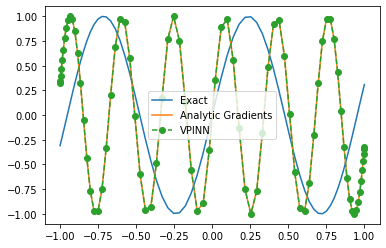

In [9]:
plt.plot(vpinn.x.detach().numpy(), u_ex(vpinn.x).detach().numpy(), label = "Exact")
plt.plot(vpinn.x.detach().numpy(), torch.sin(w_analytic*vpinn.x).detach().numpy(), '-', label = "Analytic Gradients")
plt.plot(vpinn.x.detach().numpy(), vpinn.model(vpinn.x).detach().numpy(), '--o' , label = "VPINN")
plt.legend()

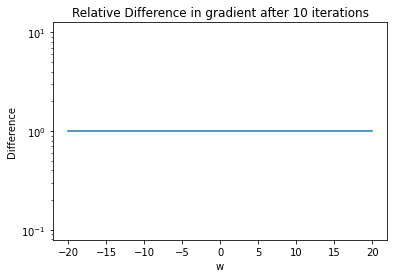

In [10]:
plt.plot(np.linspace(-20, 20, 10), diffs1)
plt.title("Relative Difference in gradient after 10 iterations")
plt.xlabel("w")
plt.ylabel("Difference")
plt.yscale('log')
plt.yscale('log')

#### Method 2

In [11]:
diffs2 = []
lr = 1e-3

for w_param in np.linspace(-20, 20, 10):

    u_approx = MLP(w_param)
    vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)

    w_analytic = w_param

    for i in range(10):
        
        # Computes the grad
        analyticGrad = computeGrad(vpinn, w_analytic, 2)

        loss_interior, loss_boundary = vpinn.compute_loss(2)
        vpinnLoss = loss_interior + loss_boundary
        vpinnLoss.backward(retain_graph=True)

        # update ws
        with torch.no_grad():
            for p in vpinn.model.parameters():
                p -= lr*p.grad
            w_analytic -= lr*analyticGrad
        vpinn.zero_grad()

    # Compute the final gradients
    analyticGrad = computeGrad(vpinn, w_analytic, 2)
    for p in vpinn.model.parameters():
        vpinnGrad = p.grad.clone()

    diffs2.append(np.abs((analyticGrad.item() - vpinnGrad.item()) / analyticGrad.item()))
print("Max Relative difference =", max(np.abs(diffs2)))

Max Relative difference = 1.0


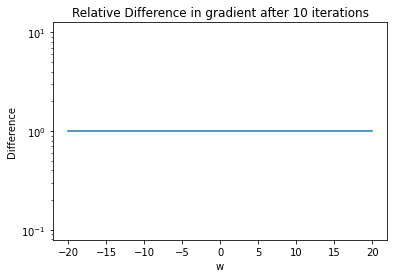

In [12]:
plt.plot(np.linspace(-20, 20, 10), diffs1)
plt.title("Relative Difference in gradient after 10 iterations")
plt.xlabel("w")
plt.ylabel("Difference")
plt.yscale('log')
plt.yscale('log')

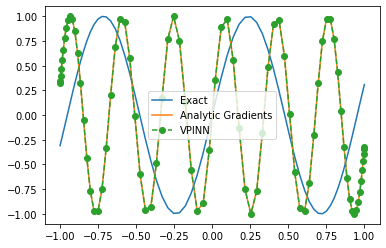

In [13]:
plt.plot(vpinn.x.detach().numpy(), u_ex(vpinn.x).detach().numpy(), label = "Exact")
plt.plot(vpinn.x.detach().numpy(), torch.sin(w_analytic*vpinn.x).detach().numpy(), '-', label = "Analytic Gradients")
plt.plot(vpinn.x.detach().numpy(), vpinn.model(vpinn.x).detach().numpy(), '--o' , label = "VPINN")
plt.legend()

#### Method 3

In [14]:
diffs3 = []
lr = 1e-3

for w_param in np.linspace(-20, 20, 10):

    u_approx = MLP(w_param)
    vpinn = VPINN_Laplace_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)

    w_analytic = w_param

    for i in range(10):
        
        # Computes the grad
        analyticGrad = computeGrad(vpinn, w_analytic, 3)

        loss_interior, loss_boundary = vpinn.compute_loss(3)
        vpinnLoss = loss_interior + loss_boundary
        vpinnLoss.backward(retain_graph=True)

        # update ws
        with torch.no_grad():
            for p in vpinn.model.parameters():
                p -= lr*p.grad
            w_analytic -= lr*analyticGrad
        vpinn.zero_grad()

    # Compute the final gradients
    analyticGrad = computeGrad(vpinn, w_analytic, 3)
    for p in vpinn.model.parameters():
        vpinnGrad = p.grad.clone()

    diffs3.append(np.abs((analyticGrad.item() - vpinnGrad.item()) / analyticGrad.item()))
print("Max Relative difference =", max(np.abs(diffs3)))

Max Relative difference = 1.0


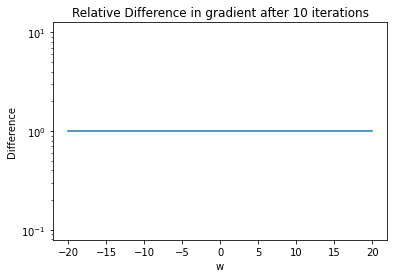

In [15]:
plt.plot(np.linspace(-20, 20, 10), diffs1)
plt.title("Relative Difference in gradient after 10 iterations")
plt.xlabel("w")
plt.ylabel("Difference")
plt.yscale('log')
plt.yscale('log')

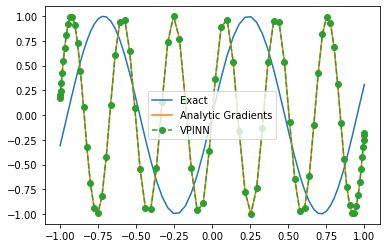

In [16]:
plt.plot(vpinn.x.detach().numpy(), u_ex(vpinn.x).detach().numpy(), label = "Exact")
plt.plot(vpinn.x.detach().numpy(), torch.sin(w_analytic*vpinn.x).detach().numpy(), '-', label = "Analytic Gradients")
plt.plot(vpinn.x.detach().numpy(), vpinn.model(vpinn.x).detach().numpy(), '--o' , label = "VPINN")
plt.legend()